In [1]:
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

# QUESTION 1

Below is some helper code shared between the 2 functions


In [ ]:
from typing import List
from math import sin, cos, tan, radians, pi, sqrt, degrees

import matplotlib.pyplot as plot
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

In [ ]:
def plot_path_x_y_angular_velocities(path_x, path_y, x_vel, y_vel,angular_momentum, radius=2.5) -> None:

    # Graph the path of the robot
    figure, axes = plot.subplots()
    
    figure.set_size_inches(9, 9)
    axes.set_title("Path")
    axes.set_xlim((-3, 3))
    axes.set_ylim((-3, 3))
    axes.add_patch(Circle((0, 0), radius, facecolor="none", ec='k', lw=2))
    for index, path in enumerate(path_x):
        axes.plot(path_x[index], path_y[index], lw=4)

    # Plot angular momentum by command (each command has constant angular momentum)
    figure, axes = plot.subplots()
    figure.set_size_inches(9, 9)
    axes.plot(angular_momentum)
    axes.set_title("Angular Momentum")
    axes.set_xlabel("Time step")

    # Plot x position by time
    figure, axes = plot.subplots()
    figure.set_size_inches(9, 9)
    axes.plot(x_vel, label="x")
    axes.set_xlabel("Time step")
    axes.set_title("Velocity X")

    # Plot y position by time
    figure, axes = plot.subplots()
    figure.set_size_inches(9, 9)
    axes.plot(y_vel, label="y")
    axes.set_xlabel("Time step")
    axes.set_title("Velocity Y")

# Section A: Skid Steer Circle

In [ ]:

class SkidRobot:
    def __init__(self, length, width, x=0, y=0) -> None:
        """Creates a robot

        Args:
            length (_type_): Uses Meters
            width (_type_): Uses Meters
        """
        self.length = length
        self.width = width
        self.x = x
        self.y = y
        self.theta = 0
    
    def move(self, velocity_left, velocity_right, dt=0.1) -> None:
        self.x -= (.5 * (velocity_left + velocity_right)) * sin(self.theta) * dt
        self.y += (.5 * (velocity_left + velocity_right)) * cos(self.theta) * dt
        self.theta += (1 / self.width) * (velocity_right - velocity_left) * dt
        
    def get_coords(self) -> "tuple[float, float]":
        return (self.x, self.y)
    
    def move_for_duration(self, duration, velocity_left, velocity_right, dt = 0.1) -> "tuple[list, list, list]":
        path_x = []
        path_y = []
        angular_momentum = []
        
        # put loop in terms of dt = 0.1
        current_time = 0
        while (current_time < duration):
            path_x.append(self.x)
            path_y.append(self.y)
            angular_momentum.append(self.get_angular_momentum(dt, velocity_left, velocity_right))
            self.move(velocity_left, velocity_right, dt)
            current_time += dt

        # Store final point
        path_x.append(self.x)
        path_y.append(self.y)
        return path_x, path_y, angular_momentum

    def get_bounds(self) -> "tuple[float, float]":
        return (self.width, self.length)

    def get_angular_momentum(self, duration, velocity_left, velocity_right) -> float:
        theta = (velocity_right - velocity_left) / self.width
        vel_x = ((velocity_right + velocity_left) / 2) * sin(self.theta)
        vel_y = ((velocity_right + velocity_left) / 2) * cos(self.theta)
        return (theta, vel_x, vel_y)
    
    def calculate_error_move(self, vl, vr, dt=0.1):
        r = self.get_r(vl, vr)
        total_velocity = (vl + vr) / 2
        total_distance = total_velocity * dt
        circumference = 2 * r * pi
        
        # Perform Move
        self.move(vl, vr, dt)
        
        # calculate theoretical position
        t_theta = (total_distance * 360) / circumference
        t_x, t_y = (cos(t_theta) * total_distance, sin(t_theta) * total_distance)
        
        # Percent error calculation
        p_x = abs(1 - (abs(self.x - t_x) / abs(t_x))) * 100
        p_y = abs(1 - (abs(self.y - t_y) / abs(t_y))) * 100
        p_theta = abs(1 - (abs(self.theta - t_theta) / abs(t_theta))) * 100
        
        return [(p_x, p_y, p_theta), (t_x, t_y, t_theta), (self.x, self.y, degrees(self.theta))]

    def get_R(self, vr, vl):
        return (self.width / 2) * ((vr + vl) / (vr - vl))

Below is the code to run the robot

In [ ]:
robot = SkidRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []


# Move 2.4m up, .3 seconds at 8 m/s 

# turn for 4 seconds at 6.1875 +- m/s

# 19 time steps

# Move to outside of the circle
duration, velocity_left, velocity_right = .3, 8, 8
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(duration, velocity_left, velocity_right)

path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum += sub_angular_momentum

# Turn in place 90
duration, velocity_left, velocity_right = 1, 0.43197, -.43197

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(duration, velocity_left, velocity_right)

path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum += sub_angular_momentum

duration, velocity_left, velocity_right = 1.9, 8.92, 7.08
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(duration, velocity_left, velocity_right)


path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum += sub_angular_momentum



## Plot the resulting path

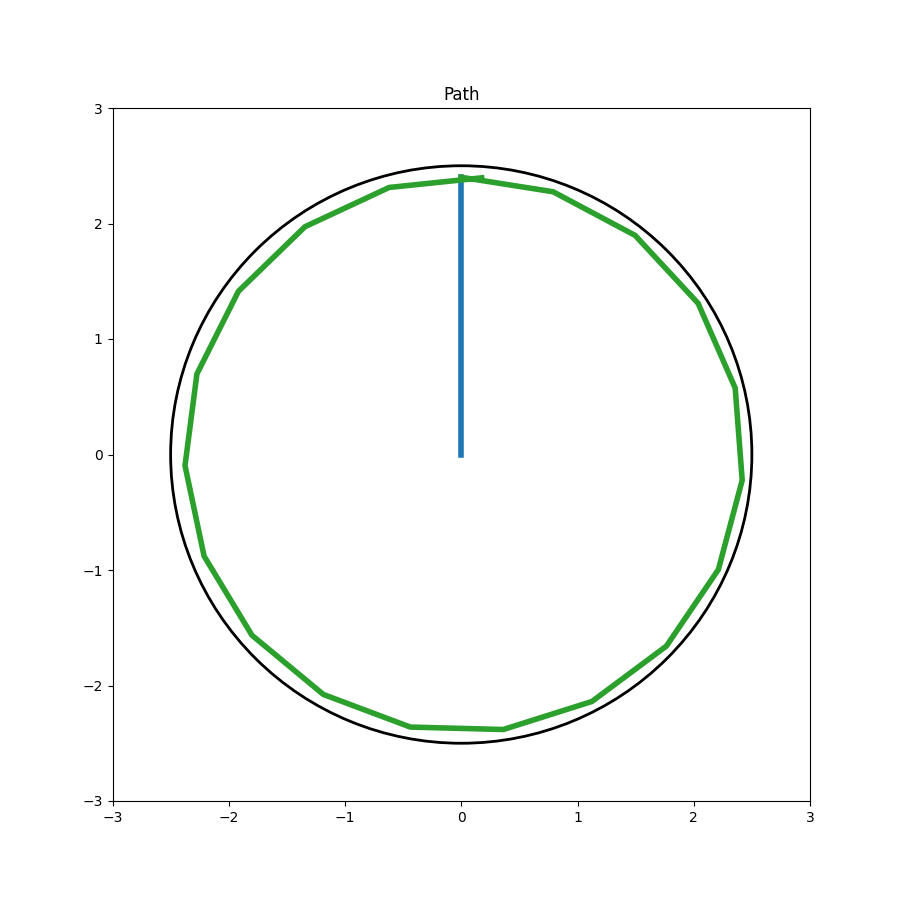

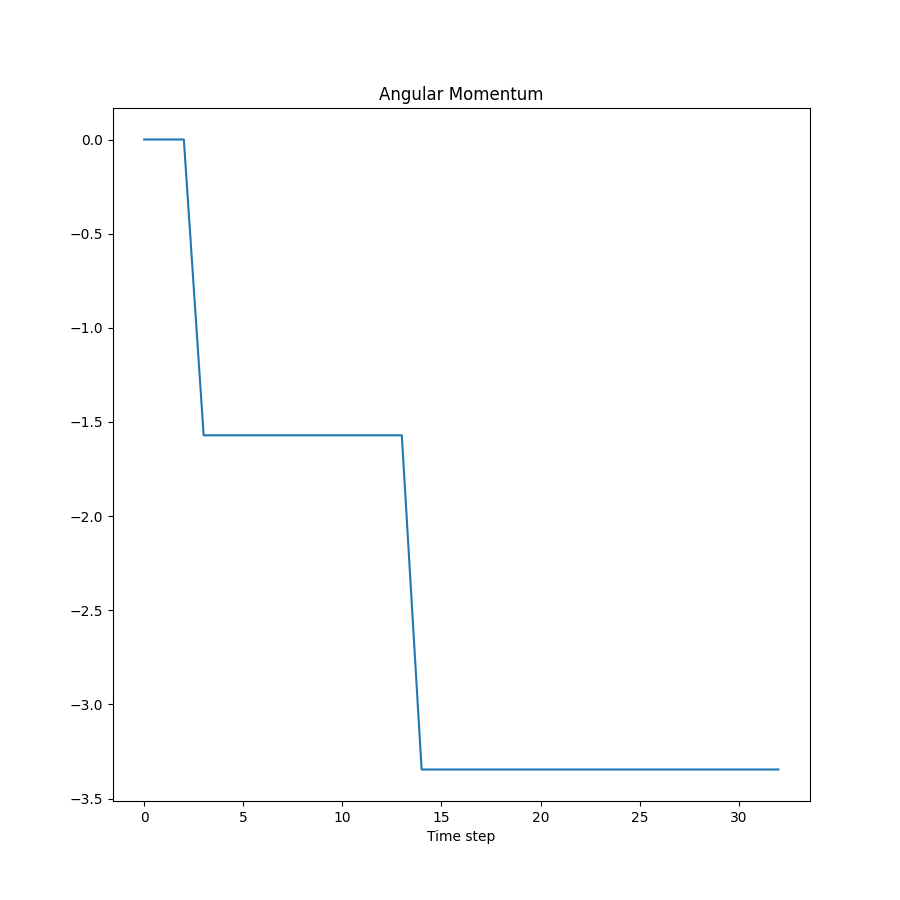

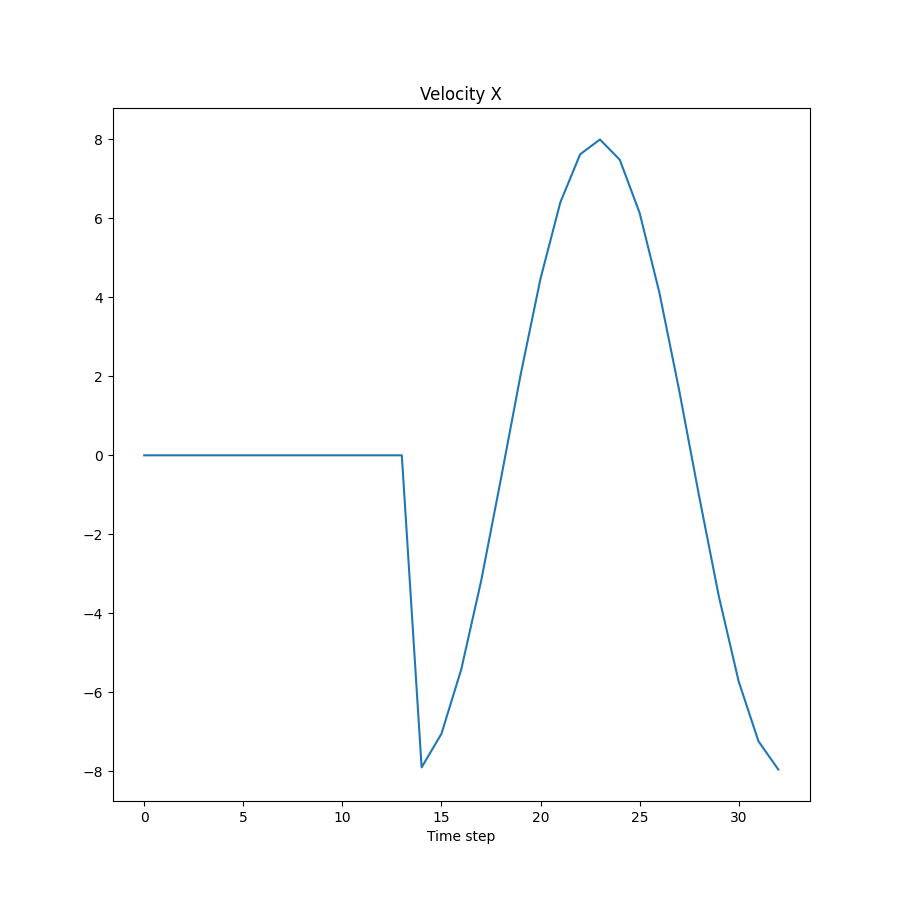

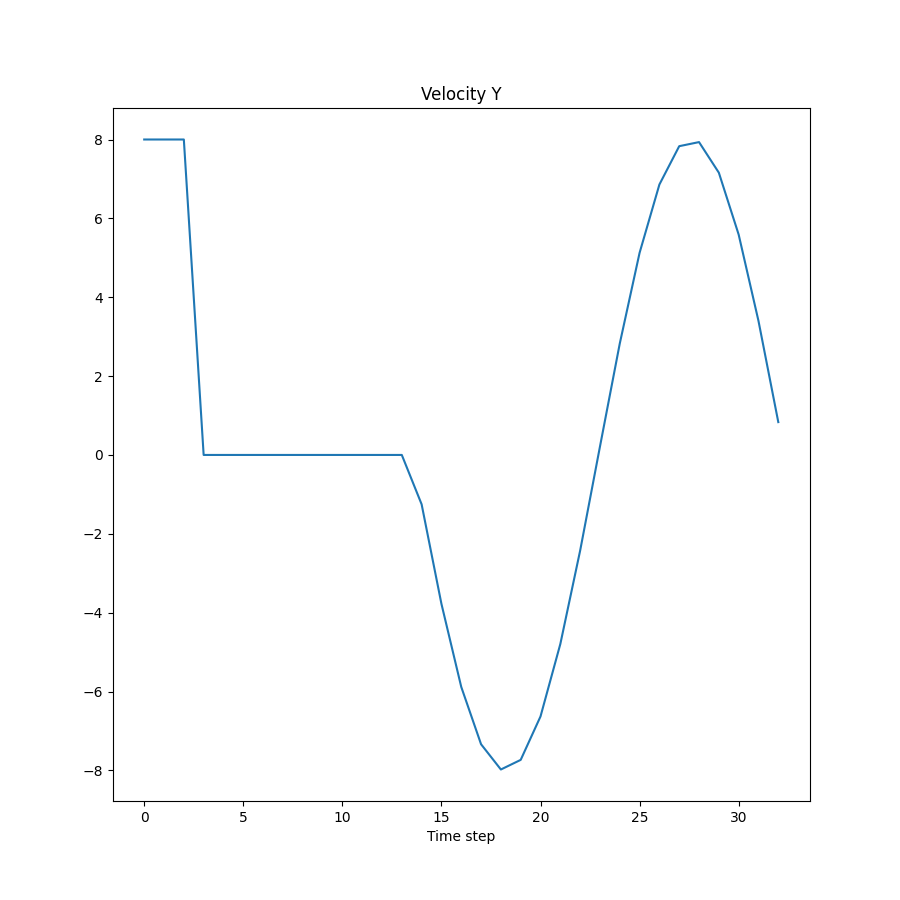

In [ ]:
angular, x_vel, y_vel = [i[0] for i in angular_momentum], [i[1] for i in angular_momentum], [i[2] for i in angular_momentum]
 
plot_path_x_y_angular_velocities(path_x, path_y, x_vel, y_vel, angular)

# Section B: Ackerman Steering

In [ ]:

from matplotlib.patches import Circle

class AckermanRobot:
    def __init__(self, length, width, x=0, y=0) -> None:
        """Creates a robot

        Args:
            length (_type_): Uses Meters
            width (_type_): Uses Meters
        """
        self.length = length
        self.width = width
        self.x = x
        self.y = y
        self.theta = 0

    def move(self, velocity: int, theta_w: int, dt=0.1) -> None:
        # Angle change for vehicle:
        if theta_w:
            self.theta += (velocity / self.get_R(velocity, theta_w)) * dt
            
        # Drive 🚓
        self.x -= velocity * sin(self.theta) * dt
        self.y += velocity * cos(self.theta) * dt
        


    def get_coords(self) -> "tuple[float, float]":
        return (self.x, self.y)

    def move_for_duration(
        self, duration, velocity, theta, dt=0.1
    ) -> "tuple[list, list, list]":
        path_x = []
        path_y = []
        angular_momentum = []

        # put loop in terms of dt = 0.1
        current_time = 0
        while current_time < duration:
            path_x.append(self.x)
            path_y.append(self.y)
            angular_momentum.append(
                self.get_angular_momentum(dt, velocity, theta)
            )
            self.move(velocity, theta, dt)
            current_time += dt

        # Store final point
        path_x.append(self.x)
        path_y.append(self.y)
        return path_x, path_y, angular_momentum

    def get_bounds(self) -> "tuple[float, float]":
        return (self.width, self.length)

    def get_angular_momentum(self, duration, velocity, theta_w) -> float:
        
        delta_theta = (velocity / self.length) * tan(theta_w)
        vel_x = -velocity * sin(self.theta)
        vel_y = velocity * cos(self.theta)
        
        return (delta_theta, vel_x, vel_y)
    def calculate_error_move(self, v, theta, duration, dt=0.1):
        guide = Circle((self.x - 2.5, self.y), 2.5, fill=False)
        tx = []
        ty = []
        e_list = []
        pathx = []
        pathy = []
        
        r = self.length / tan(theta)
        circumference = 2 * r * pi
        # Perform Move
        t_dist = 0
        current_time = 0
        while current_time < duration:
            # Perform real move
            self.move(v, theta, dt)
            
            # calculate theoretical position
            t_dist += v * dt
            t_theta = radians((t_dist * 360) / circumference)
            t_x, t_y = ((r * cos(t_theta) - 2.5), r * sin(t_theta))

            # Percent error calculation
            p_x = abs(self.x - t_x)
            p_y = abs(self.y - t_y)
            
            e_list.append((p_x**2 + p_y**2) ** 1/2)
            tx.append(t_x)
            ty.append(t_y)

            pathx.append(self.x)
            pathy.append(self.y)

            current_time += dt
            
        fig, axes = plot.subplots()
        axes.add_patch(guide)
        axes.plot(pathx, pathy, label="Actual Position")
        axes.plot(tx, ty, label="Theoretical Position")
        axes.legend()
        
        fig.show()
        return e_list
        
    def get_R(self, v, theta):      
        return self.length / tan(theta)


## Attempt 1

The below was a failed attempt, see farther down for part B's solution.  We include these here for both comedic effect and as a note of our struggles.

(-1.8859979168649792, 0.49714596878014905): 495.41009714585994


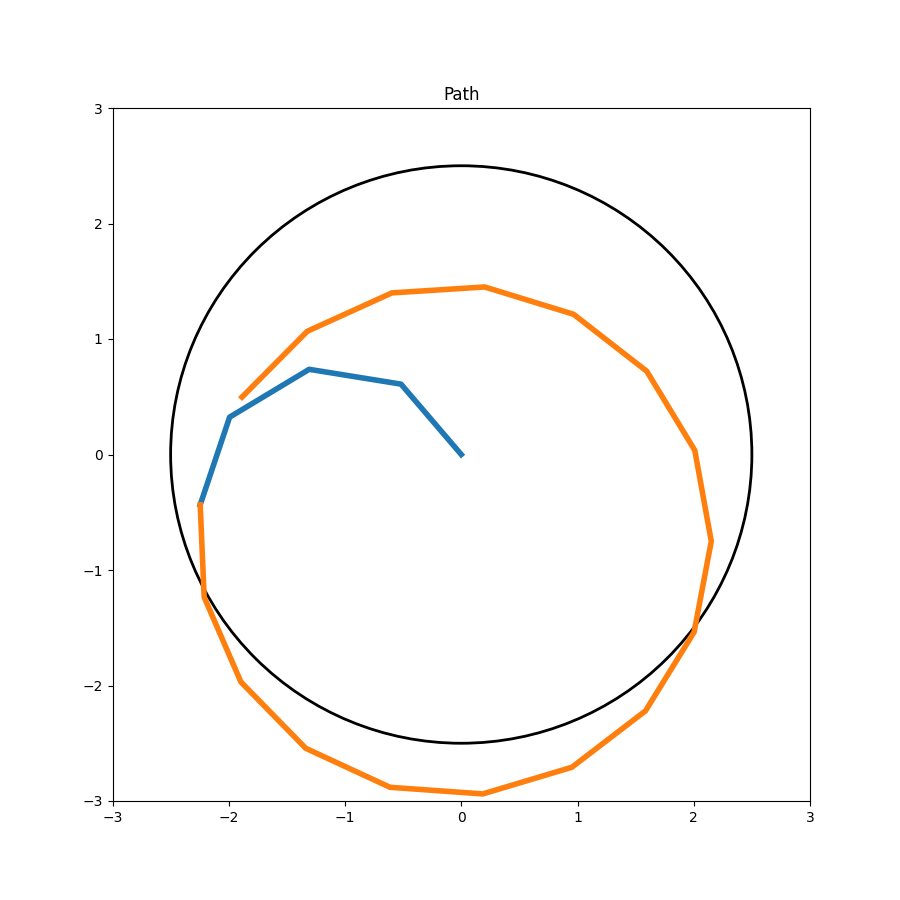

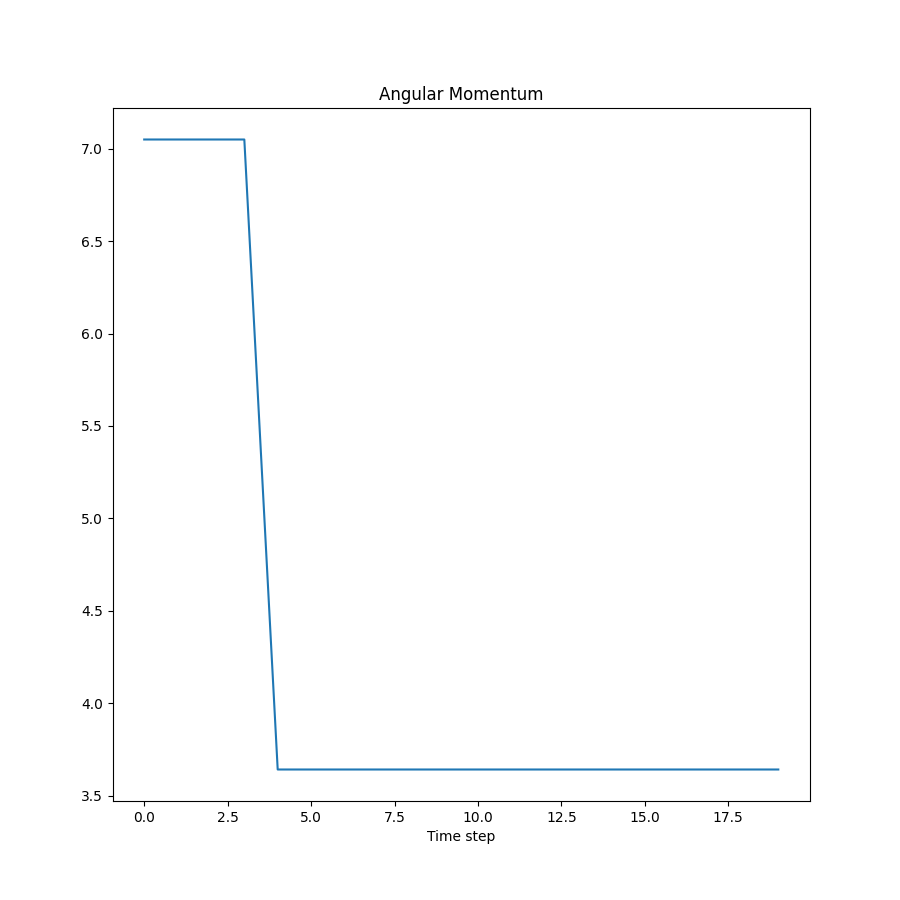

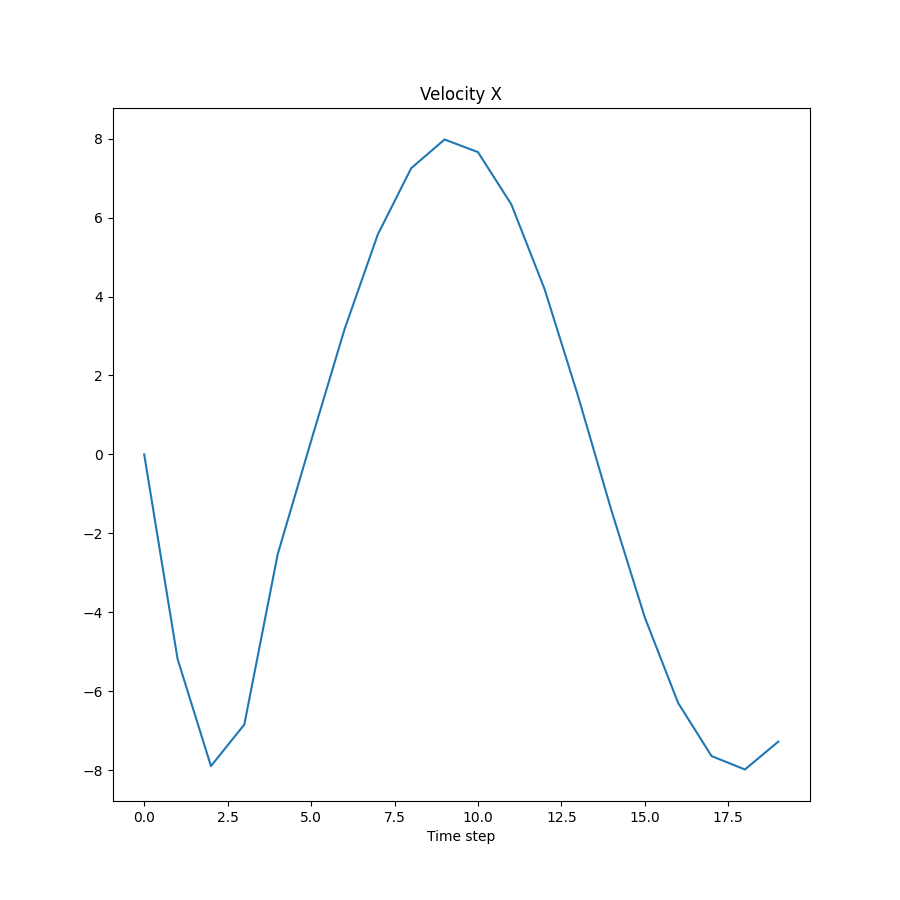

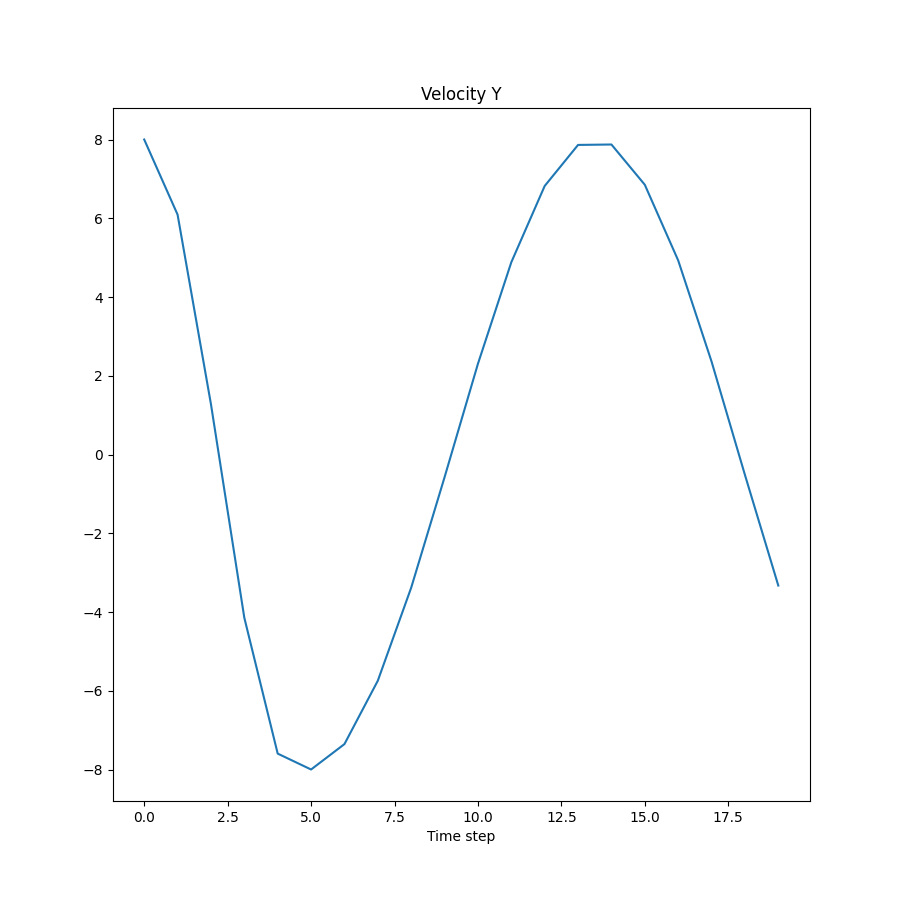

In [ ]:
robot = AckermanRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []


#First angle 0.634022719663 @ 0.4 sec

#Straight 0.1 sec

#Second angle 0.329771529972 @ ? sec

# Move to outside of the circle
# robot.theta = 0.634022719663
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.4, 8, 0.584, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum += sub_angular_momentum

# print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")
# sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.4, 8, 0.329, 0.1)
# path_x.append(sub_path_x)
# path_y.append(sub_path_y)
# print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")
# angular_momentum.append(sub_angular_momentum)

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(1.6, 8, 0.329, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum += sub_angular_momentum

print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")

angular, x_vel, y_vel = [i[0] for i in angular_momentum], [i[1] for i in angular_momentum], [i[2] for i in angular_momentum]
 
plot_path_x_y_angular_velocities(path_x, path_y, x_vel, y_vel, angular)


## Failed solution number 2, perfect circles with a not perfect velocity
Developer notes:
As we were calculating this solution, we found that if we were realistically driving to the outisde of the circle, with our given time step and velocity, this is the closest we could come to the outside of the circle.

Some fun solutions that were attempted but did not pan out were:
- Golden ration to the outside of the circle 
- Several smaller timesteps with verying thetas (too complex)


(-2.454630562118995, -0.020785978364021407): 504.7762767223712


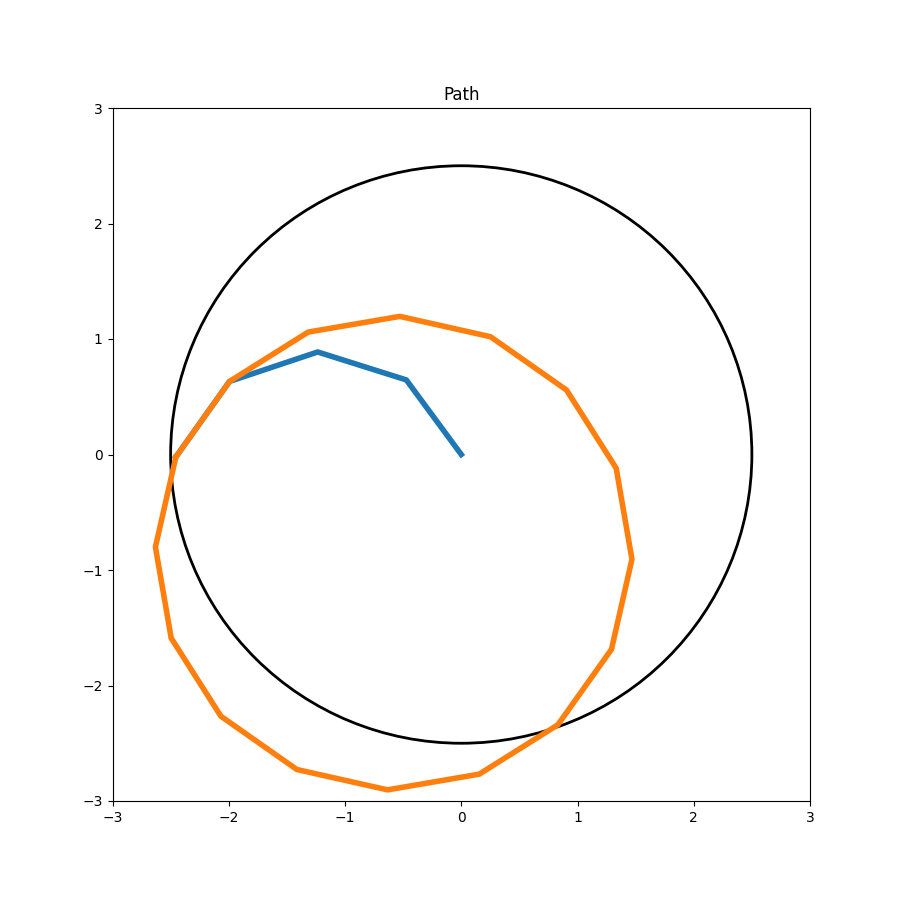

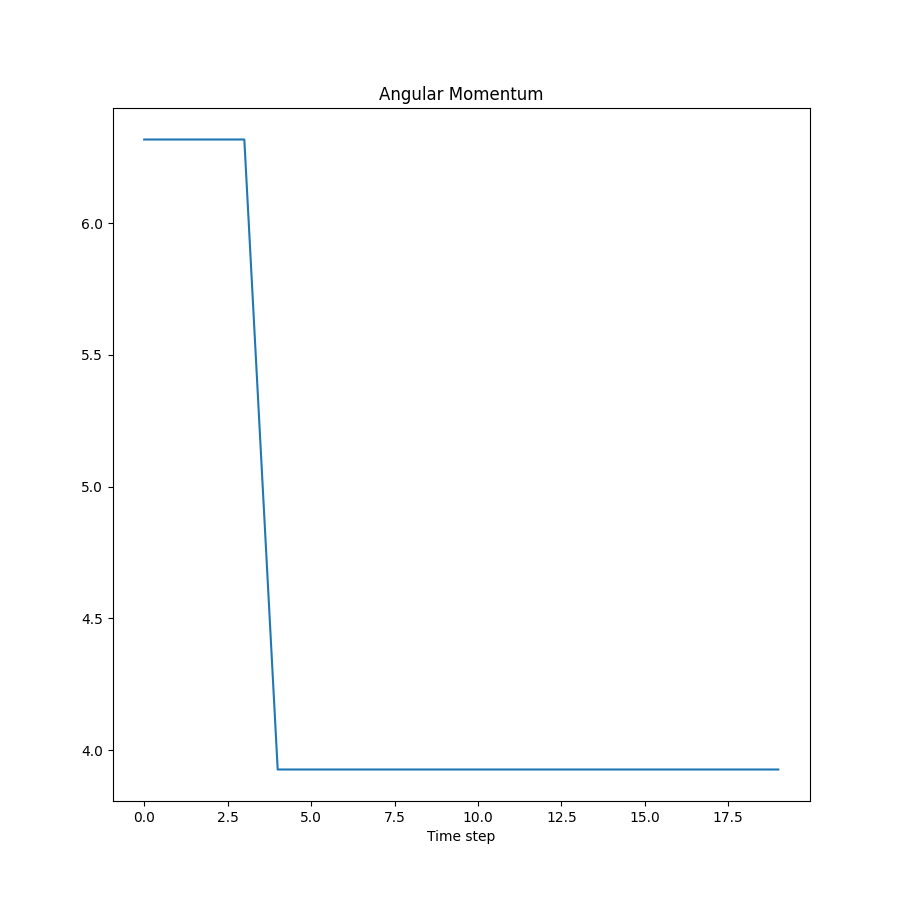

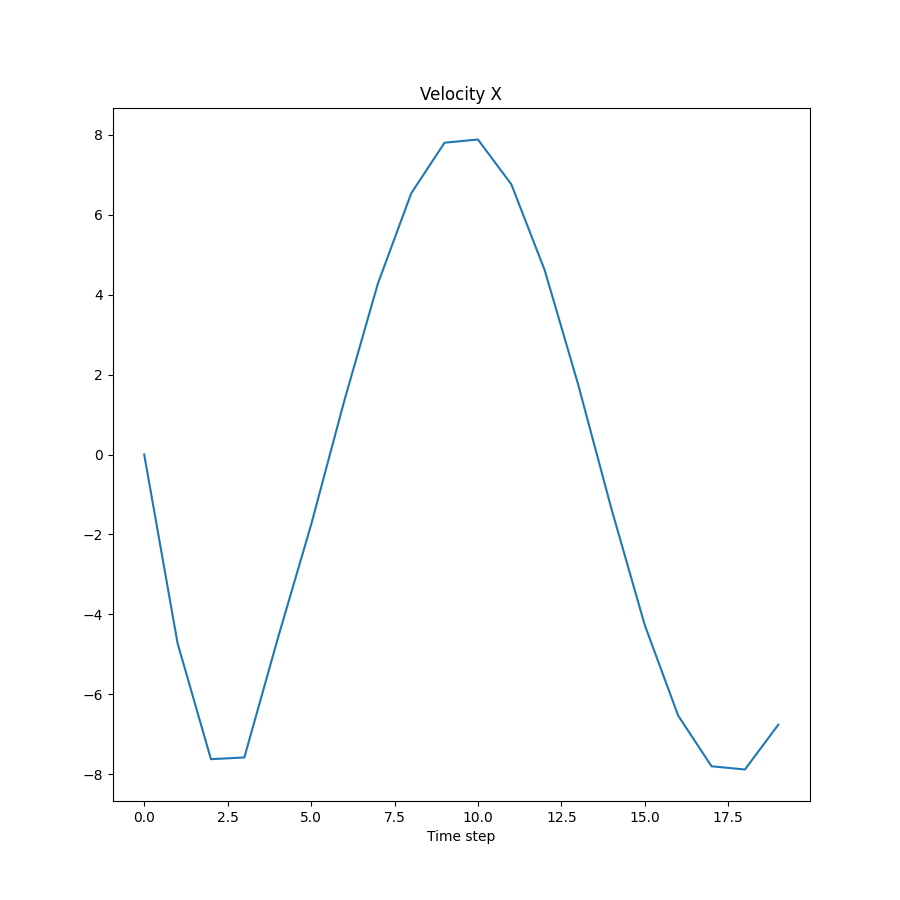

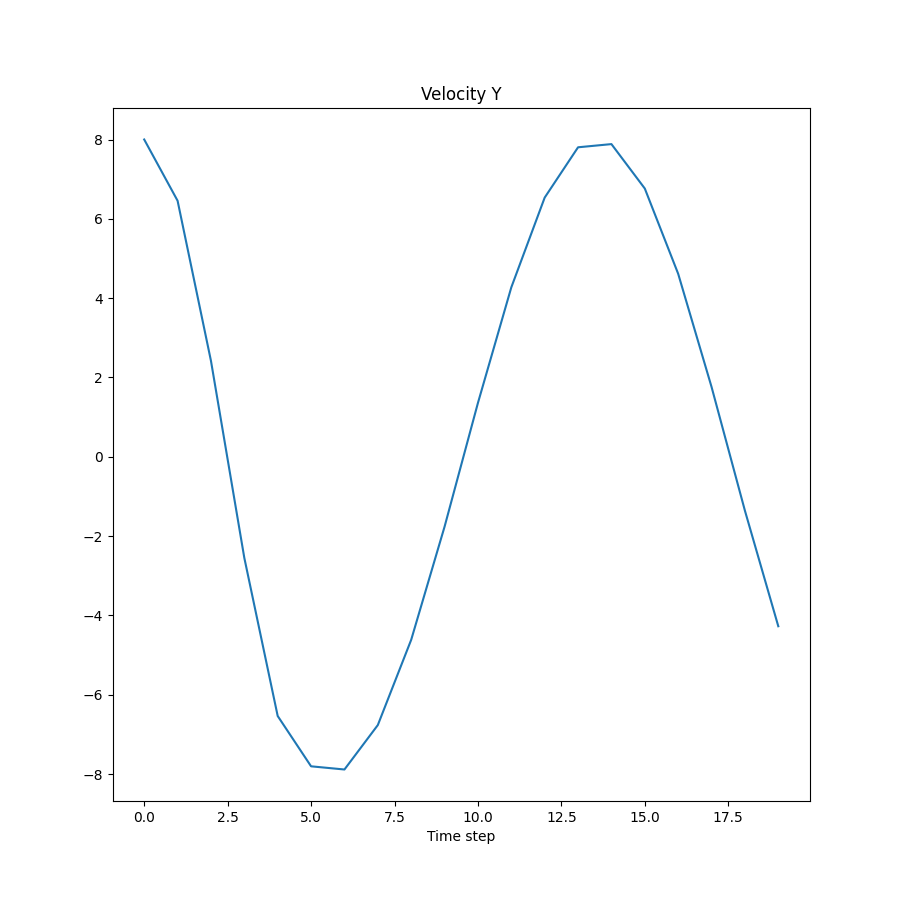

In [ ]:
robot = AckermanRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []


# Get as close as time step allows to outside of circle
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.4, 8, 0.534682287)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum += sub_angular_momentum

# Drive in a circle
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(1.6, 8, 0.3527564542)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum += sub_angular_momentum


print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")


angular, x_vel, y_vel = [i[0] for i in angular_momentum], [i[1] for i in angular_momentum], [i[2] for i in angular_momentum]
 
plot_path_x_y_angular_velocities(path_x, path_y, x_vel, y_vel, angular)


However, if we are given just a *tiny* fracting more of room in our circle (give the circle a radius of 2.6), then we can go formward one more time step and really follow the ouside of the circle.

Note: This *IS* correct without accounting for the error of the robot, which we found out early on.  One method we used to combat the error originally was to simulate smaller times steps in between larger time steps, but that went outside the learning schema of the problem

(-2.4621468293183466, -0.8000000007941204): 540.0000000263542


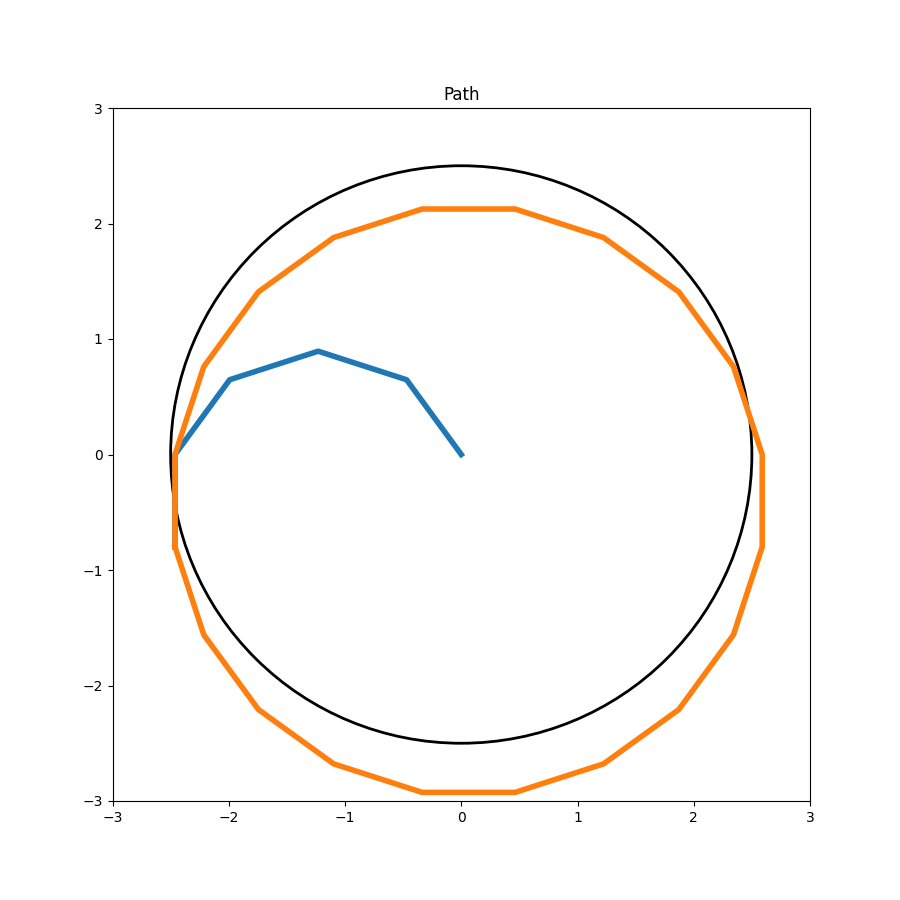

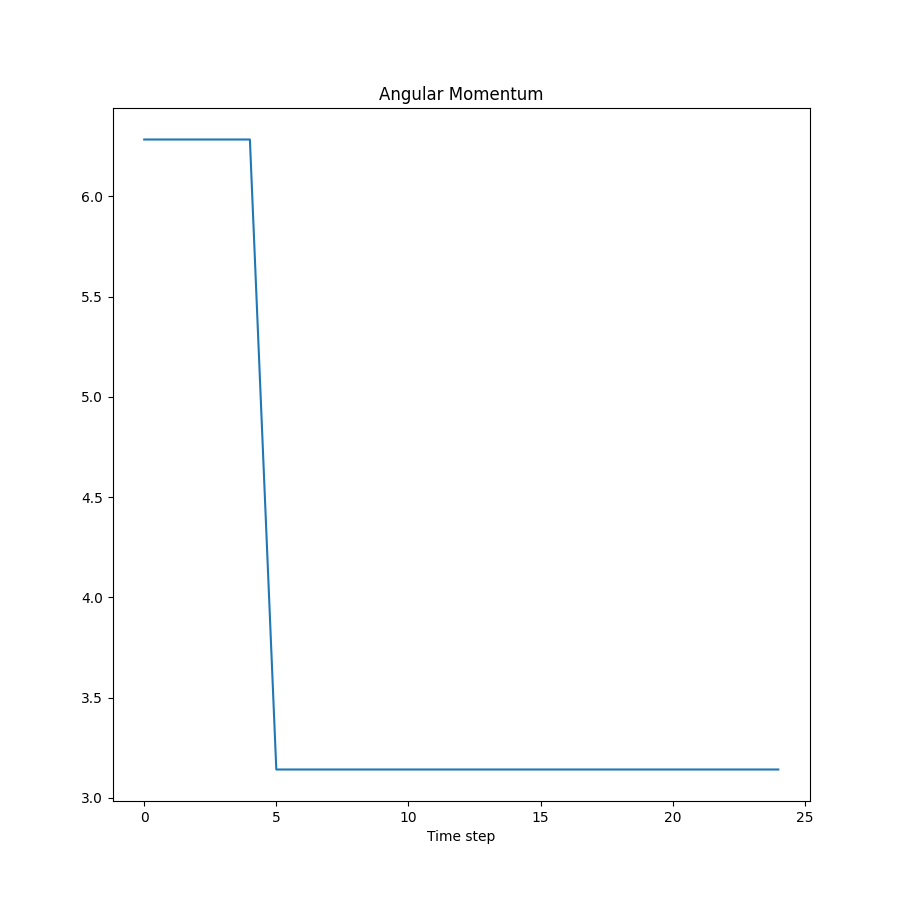

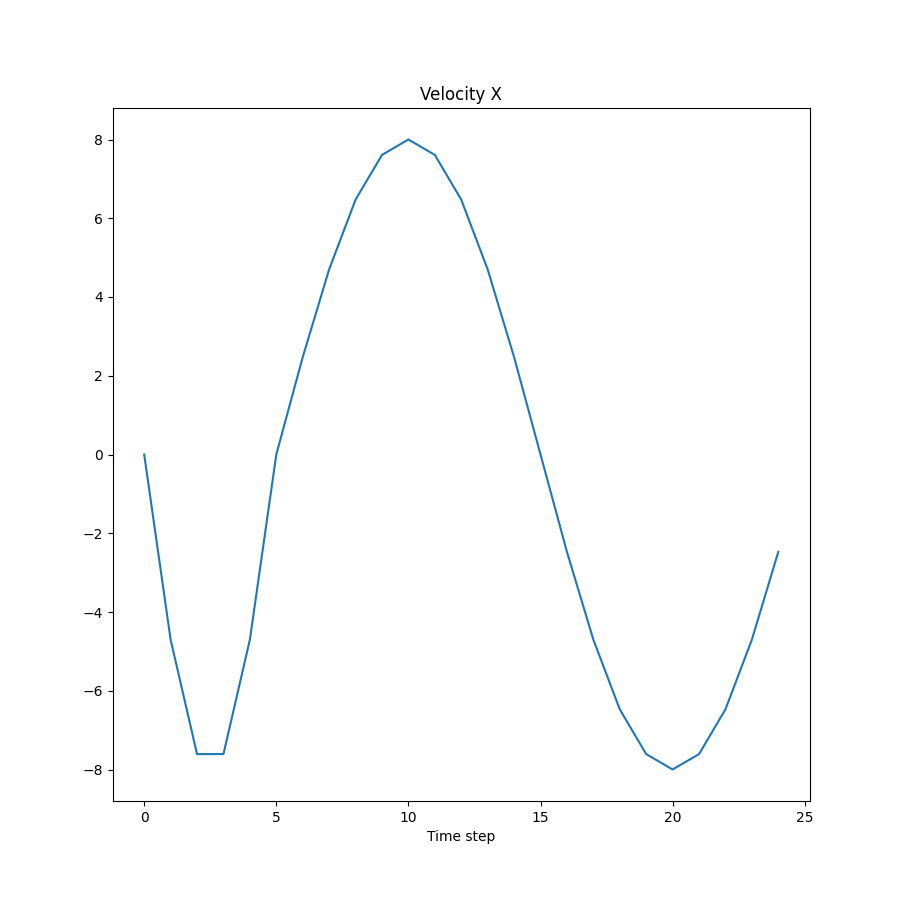

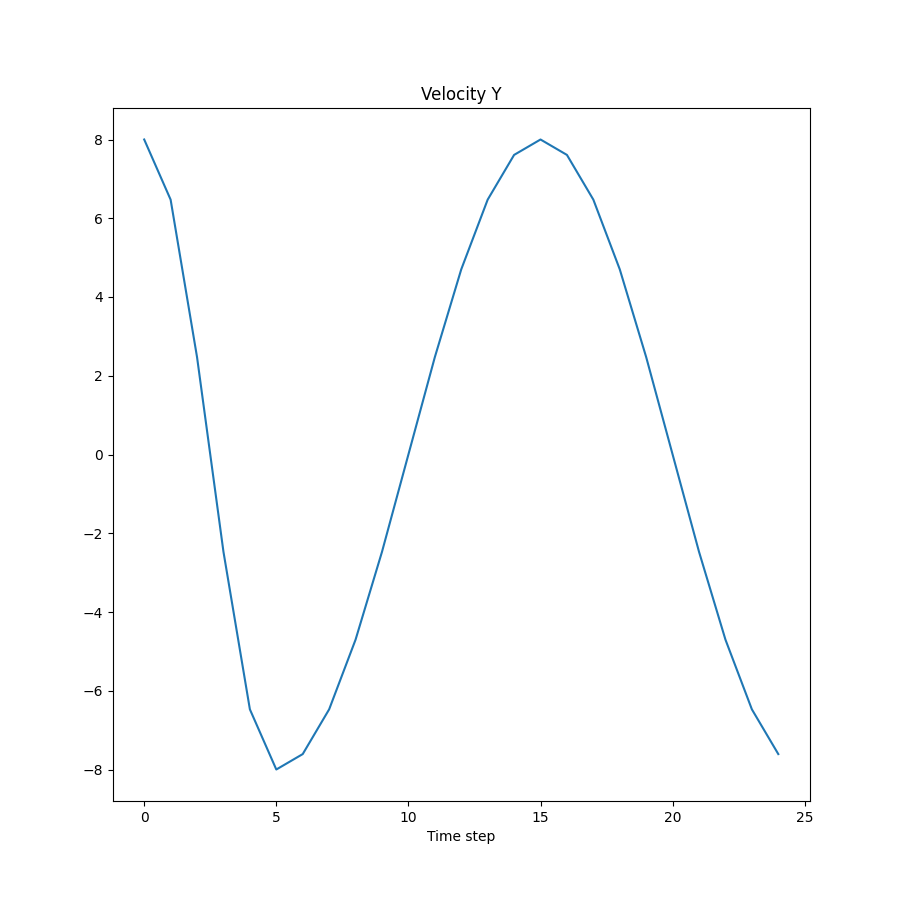

In [ ]:
robot = AckermanRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []

# Get as close as time step allows to outside of circle
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.5, 8, 0.5323280991)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum += sub_angular_momentum

# Drive in a circle
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(2, 8, 0.286425687)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum += sub_angular_momentum


print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")
angular, x_vel, y_vel = [i[0] for i in angular_momentum], [i[1] for i in angular_momentum], [i[2] for i in angular_momentum]
 
plot_path_x_y_angular_velocities(path_x, path_y, x_vel, y_vel, angular)

## Part B Solution

Our final solution worked based on a control system scheme, having the robot calculate a "next point", then calculating the angle to access the next point.

This solved all of our problems above, because now we don't need to account for our error nearly as much as we did previously by hand, and just let the robot adapt itself instead.

(-1.5838450191393938, 1.8783088862583168): 1200.7581532762115


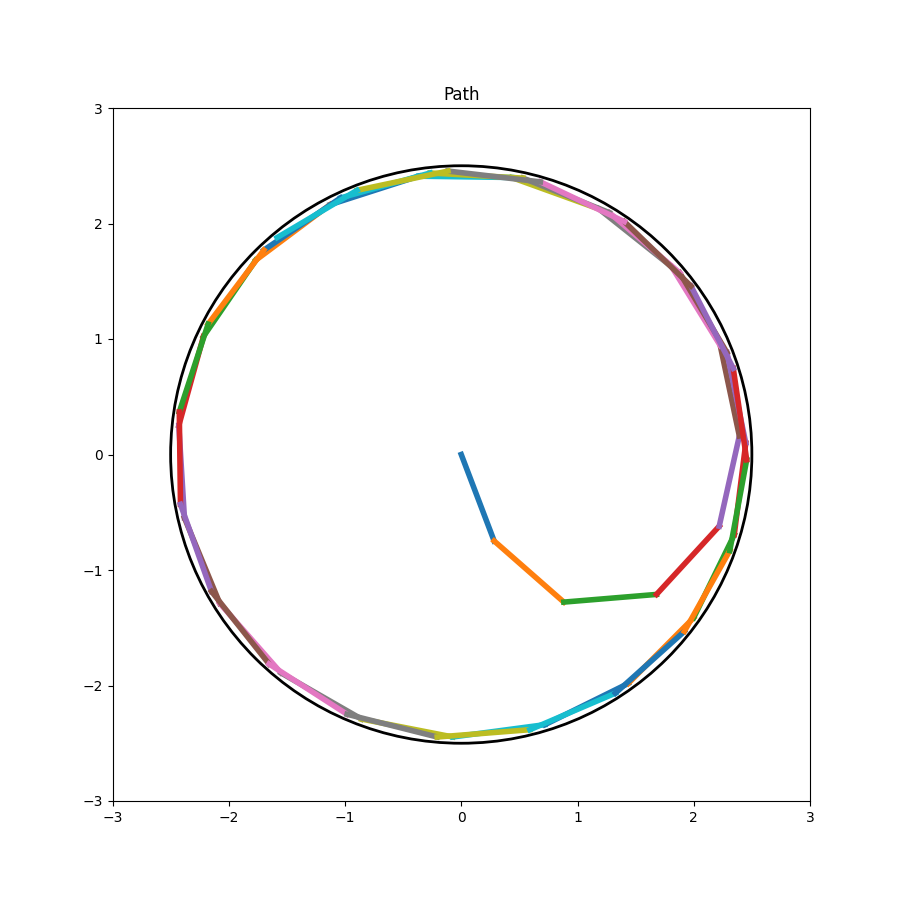

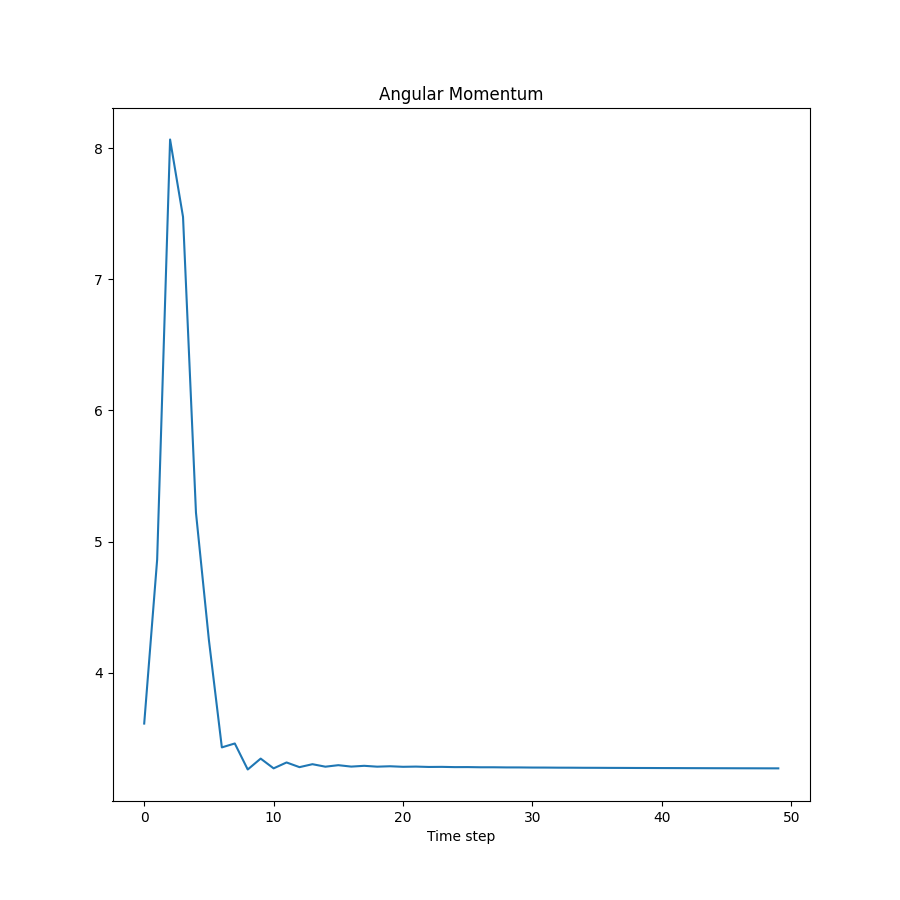

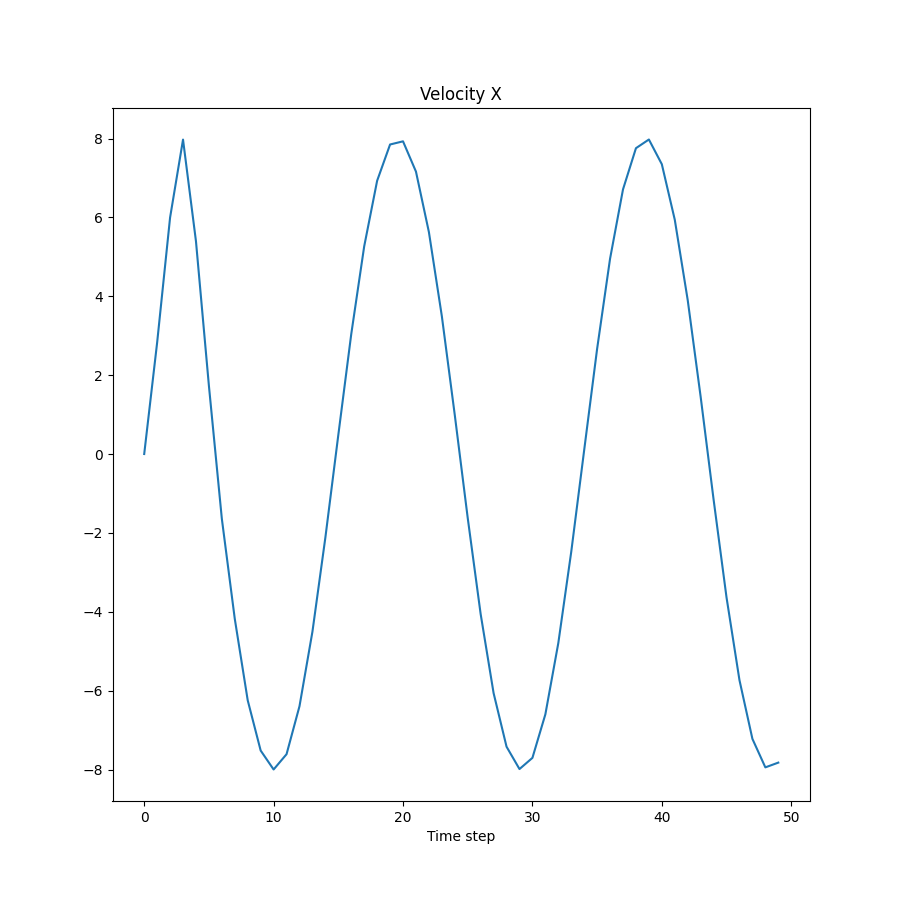

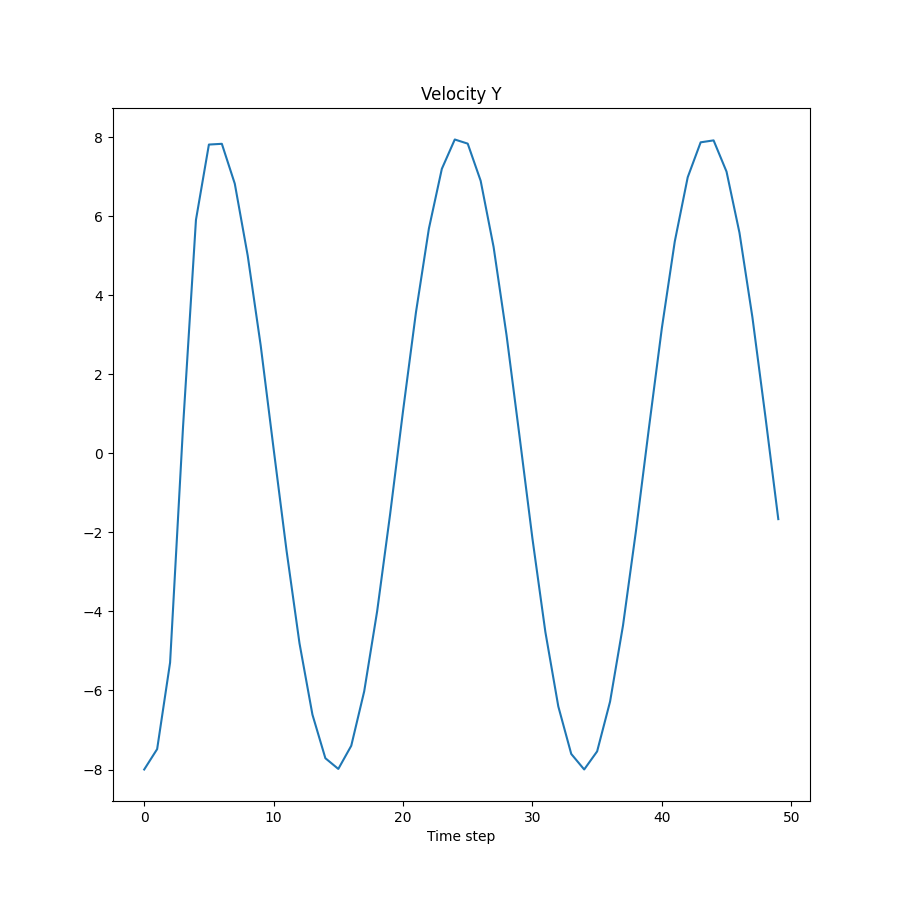

In [ ]:
from math import atan2


robot = AckermanRobot(.75, .55)
robot.theta = radians(180)
path_x = []
path_y = [] 
angular_momentum = []

target_radius = 2.45
target_circumference = target_radius * 2 * pi
center = (0, 0)
velocity = 8
t_dist = 0
t_theta = .4
dt = 0.1

for i in range(50):
    # Calculate point to reach
    t_dist += velocity * dt
    t_theta = radians(((t_dist * 360) / target_circumference)) + 1.5708
    t_x, t_y = ((target_radius * cos(t_theta)), target_radius * sin(t_theta))
    
    t_angle = atan2(t_y + robot.y, t_x + robot.x) + 1.5708
    # Calculate theta to reach pointt
    t_angle += -robot.theta
    
    sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.1, 8, t_angle, 0.1)
    dist = (robot.x **2 + robot.y **2) ** 1/2
   
    path_x.append(sub_path_x)
    path_y.append(sub_path_y)
    angular_momentum += sub_angular_momentum

print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")

angular, x_vel, y_vel = [i[0] for i in angular_momentum], [i[1] for i in angular_momentum], [i[2] for i in angular_momentum]
 
plot_path_x_y_angular_velocities(path_x, path_y, x_vel, y_vel, angular)


## Section C: Calculating Error

Below is a graph of the error over time.  Its interesting to note both here, and in our failed attempts for B, how the compound error over time can throw off the results of the robot so dramatically.

C:\Users\dalyn\AppData\Local\Temp\ipykernel_23492\3605243232.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plot.subplots()


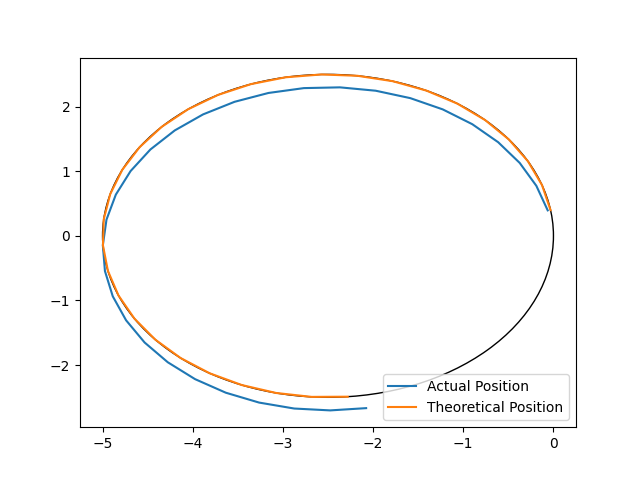

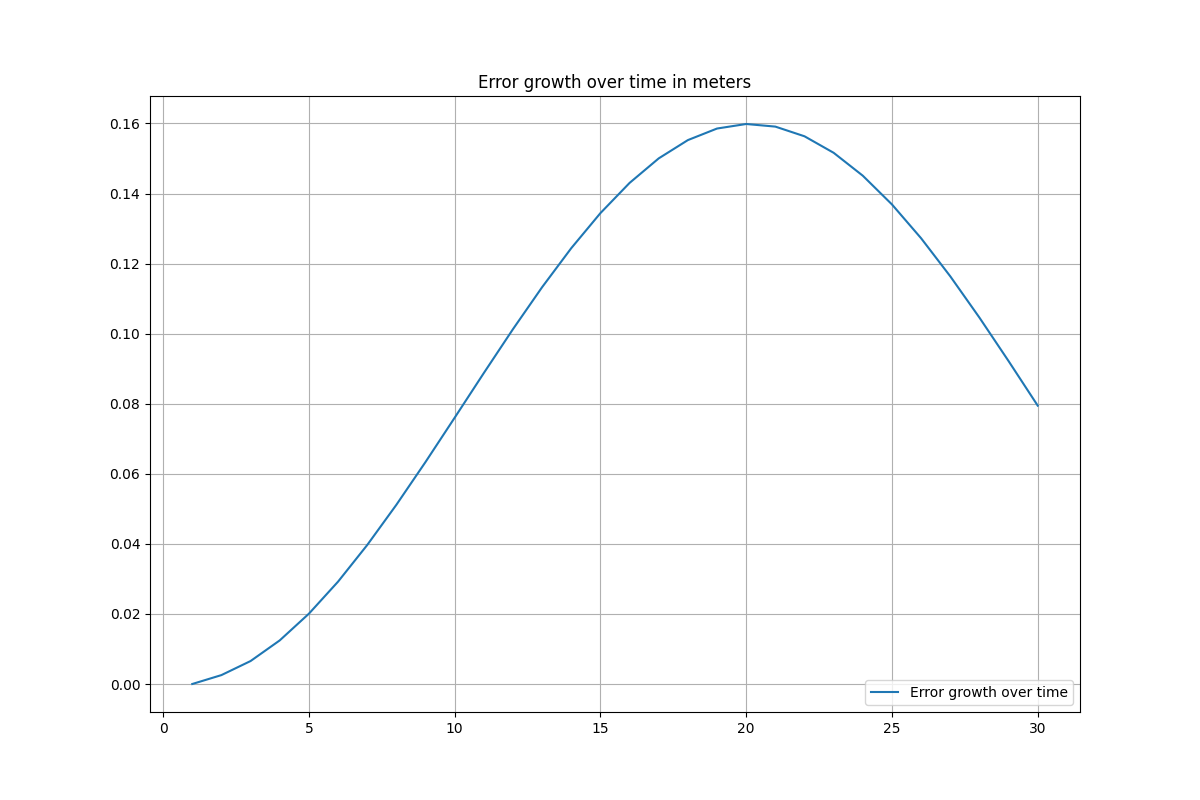

[0.0005112722880477044, 0.002032028480161496, 0.0045234202005480974, 0.007921803768317796, 0.01214036600288643, 0.01707134190428513, 0.02258876755677329, 0.028551697931640134, 0.034807807389027896, 0.04119728090239527, 0.04755689660261216, 0.05372419535132074, 0.059541630830010434, 0.06486059412898162, 0.06954521002632749, 0.07347580797934629, 0.0765519791604021, 0.07869514144392624, 0.0798505468208647, 0.07998867996028619, 0.07910601219129598, 0.07722509164446933, 0.07439396725008146, 0.07068496130736701, 0.06619282198005592, 0.06103230291347818, 0.05533523180297812, 0.04924714279832095, 0.04292355877078982, 0.03652601841405214]


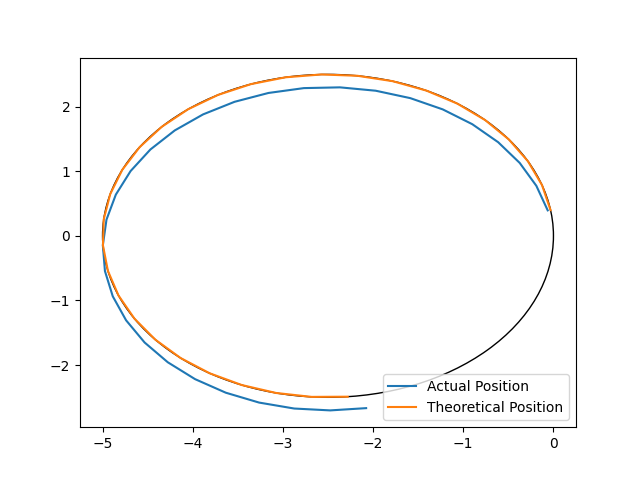

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

robo = AckermanRobot(.75, .55)
e = robo.calculate_error_move(4, 0.291456794478, 3, .1)
error_sum = np.zeros(len(e))
for i in range(1, len(e)):
    error_sum[i] = e[i-1] + e[i]
    

plt.figure(figsize = (12, 8))
plt.plot(range(1, len(e) + 1), error_sum, label="Error growth over time")
plt.title('Error growth over time in meters')
plt.grid()
plt.legend(loc='lower right')
plt.show()

print(e)